In [1]:
import scipy
import xarray as xr
import grib2io
import pandas as pd
import datetime
from glob import glob
import numpy as np
from corner import quantile
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import matplotlib
matplotlib.rcParams.update({
 "savefig.facecolor": "w",
 "figure.facecolor" : 'w',
 "figure.figsize" : (8,6),
 "text.color": "k",
 "legend.fontsize" : 20,
 "font.size" : 30,
 "axes.edgecolor": "k",
 "axes.labelcolor": "k",
 "axes.linewidth": 3,
 "xtick.color": "k",
 "ytick.color": "k",
 "xtick.labelsize" : 25,
 "ytick.labelsize" : 25,
 "ytick.major.size" : 12,
 "xtick.major.size" : 12,
 "ytick.major.width" : 2,
 "xtick.major.width" : 2,
 "font.family": 'STIXGeneral',
 "mathtext.fontset" : "cm"})
from PIL import Image
import statsmodels.api as sm
from statsmodels.distributions.empirical_distribution import ECDF
from mpl_toolkits.basemap import Basemap
from pyproj import Proj
from metpy.units import units
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

## Data Assimilation and Coalescence

The process of combining observations and short-range forecasts to obtain an initial condition for NWP is called data assimilation. In the most general terms, data assimilation techniques attempt to combine theoretical models with observations in the "best way possible" to improve both sets of data.  This amounts to rectifying errors in both the forecast (magnitude, location and timing of event) and the necessarily sparse observations of the true system state: "for large scale systems, it is almost impossible to experimentally measure the full state of the system at a given time. For example, imagine simulating the atmospheric or oceanic flow, then you need to measure the velocity, temperature, density, etc. at every location corresponding to your numerical grid," (Ahmed+2020).

Data assimilation proceeds sequentially in time, applying a correction to the forecast based on a set of observed data and estimated errors that are present in both the observations and the forecast itself. The model organizes and propagates forward the information from previous observations. As new observations are added, that data is used to modify the model state to be as consistent as possible with them (i.e., data) *and* the previous information --> a sort of ouroboros of analysis and forecast.

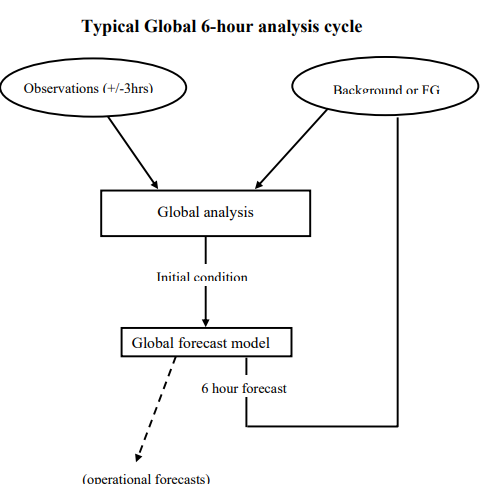


The very first step of the data assimilation cycle (which we don't see as it happens pre-blend) is the production of something like URMA -- taking irregularly spaced observations (both direct and indirect) of atmospheric state variables and estimating them onto a regular grid (e.g., spatial analysis of which there are several techniques that can be applied). Once gridded, these can be modified by the background field. And then applied to numerical models as a supplement for the ICs. 

In essence, this amounts to a pre-process for NWP but can also be used to combine predictions from several models + corrections from contemporaneous observations == the blend! In particular, correcting for the errors in the forecasts associated with both position and amplitude is difficult; "the standard measures of forecast skill, such as root-meansquare (r.m.s.) error and anomaly correlation all measure forecast error as the difference between a forecast and ananalysis at the same point in space and time. They are incapable of identifying a phase error as such. For example, a forecast of an intense, fast-moving feature can have a low skill score because of a small phase error that a human forecaster may consider minor. Hence, there is a need for an objective skill evaluation method that accounts for the presence of both phase and amplitude errors" (Nehrkorn+2003). 

Related is the treatment of probabilistic forecasts generated from ensembles of perturbed models. In the blend, there are ~17 models used to construct the value distributions for each variable (temp, precip, etc.). Some of these models are themselves made of an ensemble of models with different perturbation states (so in reality, 200+ realizations). In QM, each of these ensemble members would be mapped to the CDF constructed from the entire sample, but this can introduce issues originating from errors in the magnitude, timing, and location of weather events as predicted by the model. Furthermore, while QM (theoretically) provides really great probabilitic predictions for weather events, it's difficult to know how to communicate more deterministic estimates from an ensemble. 

An improvement we hope to make to the blend is to somehow efficiently combine the physically meaningful information encoded in the entire distribution of predictions from the ensemble. One way to do that is via coalescence, which seeks to quantify the uncertainity for coherent structures that can suffer multiple types of error in an ensemble of forecasts (as in above, it is necessary to correct for both phase and amplitude errors). "Consider, as an illustration, an ensemble of “one dimensional” fronts that contain position and amplitude errors, as shown in (the Figure below). If we were to ask what the mean front is, clearly the simplest solution is to take the mean of these fields, that is, calculate the mean vector. That would be terribly wrong, of course, because the mean simply does not look like any front in the ensemble. Coalescence instead calculates the mean amplitude field by marginalizing relative position errors. The method invokes an “N-body” type solution where each member in the ensemble gravitates to the others. In so doing, all of them discover a mean position where the amplitude mean is meaningful," (Ravela+2012)

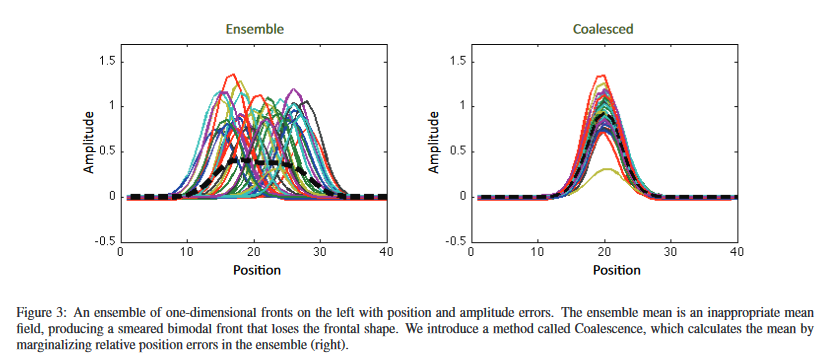

Here, I'll attempt to walk through some examples outlined in the handy beginner-level demo Ahmed+2020 and then expand to the technique of coalesence as defined in Ravela+2012.

## Data Assimilation as in Ahmed+2020

As a starting point in Ahmed+2020, we begin by defining a state vector **u** that evolves over time which describes all of the information about the actual state of (in our case) the atmosphere. The time evolution of the state is governed by a set of dynamical equations (which, unfortunately for us and is really the impetus of this entire process, are very very sensitive to the input initial conditions). **u$_t$** is then the vector of true values of the state. The background **u$_b$** contains prior information about the state of the system currently. Of course, we cannot observe all of the aspects of the system so the collection of information we actually know about the system at a specific time is **w**(t). In fact, we usually cannot directly observe most of the physical quantities of the state (e.g., temperature, humidity) and instead observe them indirectly via radar measurements. In light of this, **w** is related to **u$_t$** via a mapping *h* (observation operator) between state space and measurement space (plus some measurement noise/errors.)

The objective of DA is to combine our prior knowledge of the system state (**u$_b$**) and observations (**w**) to approximate the true state of the system (**u$_t$**). This approximation is the analysis **u$_a$**. 

To demonstrate how this works, we'll use an example dynamic system (called Lorenz 63) that has been well tested. We'll walk through the 3D variational DA method (though not an exhaustive derivation) and how we can optimize the analysis from simple assumptions about the background and measurement errors.

In [78]:
def Lorenz63(state,sigma,beta,rho):
    x, y, z = state #Unpack the state vector
    f = np.zeros(3)
    f[0] = sigma * (y - x) #dx/dt
    f[1] = x * (rho - z) - y #dy/dt
    f[2] = x * y - beta * z #dz/dt
    return f 

#and to compute time derivatives, use Runge-Kutta method
def Runge_Kutta(eq,state,dt,*args):
    
    k1 = eq(state,*args)
    k2 = eq(state+k1*dt/2,*args)
    k3 = eq(state+k2*dt/2,*args)
    k4 = eq(state+k3*dt,*args)

    new_state = state + (dt/6)*(k1+2*k2+2*k3+k4)
    return new_state

Under 3DVAR, we aim to optimize the cost function *J*(**u**) in order to find **u$_a$**:

$$ \textit{J}(\textbf{u}) = {1 \over 2} {(\textbf{w} - \textit{h}(\textbf{u}))^{\textit{T}} \textbf{R}^{-1}(\textbf{w} - \textit{h}(\textbf{u}))} + {1 \over 2} {(\textbf{u} - \textbf{u}_b)^{\textit{T}} \textbf{R}^{-1}(\textbf{u} - \textbf{u}_b)} $$


where **R** is the covariance matrix of the observations (minus the observation operator) and **B** is the covariance matrix of the background. We optimize *J*(**u**) by taking the gradient and setting to zero. After some (gross) matrix operations and assuming linearity, we arrive at a solution for **u$_a$**:

$$ \textbf{u}_a = {\textbf{u}_b + \textbf{B}\textbf{H}^{\textit{T}}} (\textbf{R} + \textbf{H} \textbf{B} \textbf{H}^{\textit{T}})^{-1} (\textbf{w} - \textbf{H}\textbf{u}_b) $$

where **H** = **D**(**u**) (Jacobian matrix of *h*) for a linear observation operator *h*(**u**) = **Hu**. Ahmed+2020 describe this solution as the observation-space solution. **u$_a$** can also be solved in model-space with some re-arranging. This can be helpful if, e.g., there are less parameters in model-space vs. observation-space (since that would impact the dimension of the various matrices).

In [3]:
def ua_3DVAR(ub,w,H,R,B,opt):
    A = R + H@B@(H.T) #R + HBH^T
    b = (w-H@ub) #w-Hu_b
    ua = ub + B@(H.T)@np.linalg.solve(A,b) 
        
    return ua

In [37]:
#set up our test case

#Lorenze params
sigma=10.
beta=8./3.
rho=28.

#time evo
dt=0.01
end_t = 10.
t = np.arange(0,end_t+dt, dt)

ut_t0 = np.array([1,1,1]) # True initial conditions
ut = np.zeros([3,1000+1]) #true x,y,z, evolving for t=1000 units but need to add one for IC slot
ut[:,0] = ut_t0
for k in range(1,len(t)):
    ut[:,k] = Runge_Kutta(Lorenz63,ut[:,k-1],dt,sigma,beta,rho)

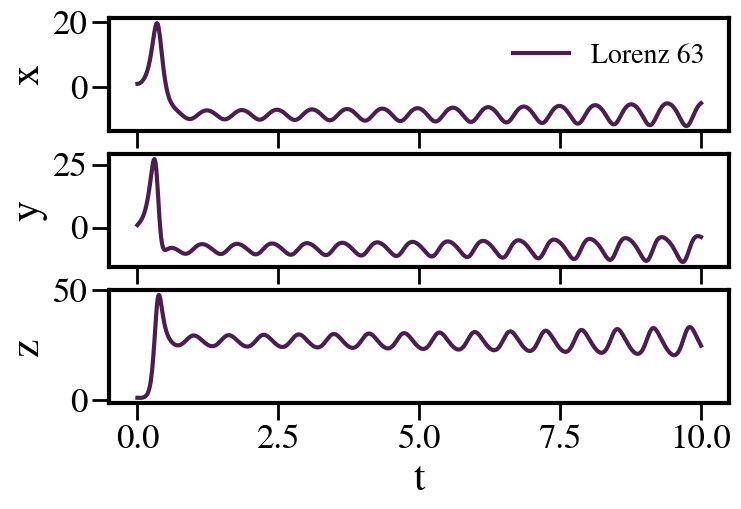

In [30]:
fig, axes = plt.subplots(3,1, sharex=True, figsize=(8,5))
labels = ['x', 'y', 'z']

for i in range(3):
    axes[i].plot(t, ut[i], lw=3,color='#4C1E4F', label='Lorenz 63')
    axes[i].set_ylabel(labels[i])


axes[2].set_xlabel('t')
axes[0].legend(frameon=False)

In [51]:
## sample observations. let's assume we only observe the first 2 seconds of evolution at every 0.2s
dt_m = 0.2 #time period between observations
tm_m = 2 #maximum time for observations
nt_m = int(tm_m/dt_m) #number of observation instants

ind_m = (np.linspace(int(dt_m/dt),int(tm_m/dt),nt_m)).astype(int)
t_m = t[ind_m]

#BUT we also need to consider our measurement errors / observation operator
#for this example, we'll just assume a 1:1 mapping between observation and system state; i.e., h(u) = u so H is just the identity matrix
H = np.eye(3)

#measurements are assumed to have Gaussian noise with mu=0 and sigma = 0.15 (for all components)
sig_m= 0.15  # standard deviation for measurement noise
R = sig_m**2*np.eye(3) #covariance matrix for measurement noise

num_obs=0
w = np.zeros([3,nt_m]) #measurement

while num_obs < nt_m:
    for obs_time in t_m:
        obs = ut[:,np.where(t == obs_time)[0][0]]
        w[:,num_obs] = H@obs + np.random.normal(0,sig_m,[3,])
        num_obs +=1


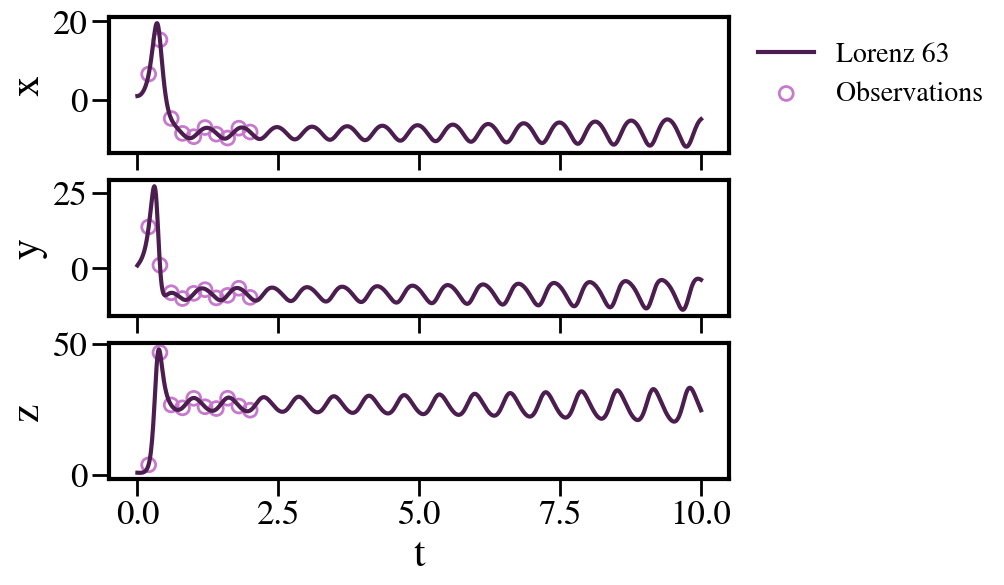

In [74]:
fig, axes = plt.subplots(3,1, sharex=True, figsize=(8,6))
labels = ['x', 'y', 'z']

for i in range(3):
    axes[i].plot(t, ut[i], lw=3,color='#4C1E4F', label='Lorenz 63')
    axes[i].set_ylabel(labels[i])

    axes[i].scatter(t_m, w[i], marker='o', facecolor='None', lw=2,s=100, edgecolor='#C77ACD', label='Observations')


axes[2].set_xlabel('t')
axes[0].legend(frameon=False, bbox_to_anchor=(1.45,1))

In [79]:
#now for data assimilation

ub_t0 = np.array([2.0,3.0,4.0]) #initial condition for the background
#assume background covariance with sigma = 0.1
sig_b= 0.1 
B = sig_b**2*np.eye(3)


ub = np.zeros([3,len(t)])
ub[:,0] = ub_t0

#analysis, initialize at background
ua = np.zeros([3,len(t)])
ua[:,0] = ub_t0

km = 0
for k in range(nt):
    ub[:,k+1] = Runge_Kutta(Lorenz63,ub[:,k],dt,sigma,beta,rho)
    ua[:,k+1] = Runge_Kutta(Lorenz63,ua[:,k],dt,sigma,beta,rho)

    if (km<nt_m) and (k+1==ind_m[km]): #replace background with observations if available
        ua[:,k+1] = ua_3DVAR(ua[:,k+1],w[:,km],H,R,B,3)  
        km = km+1

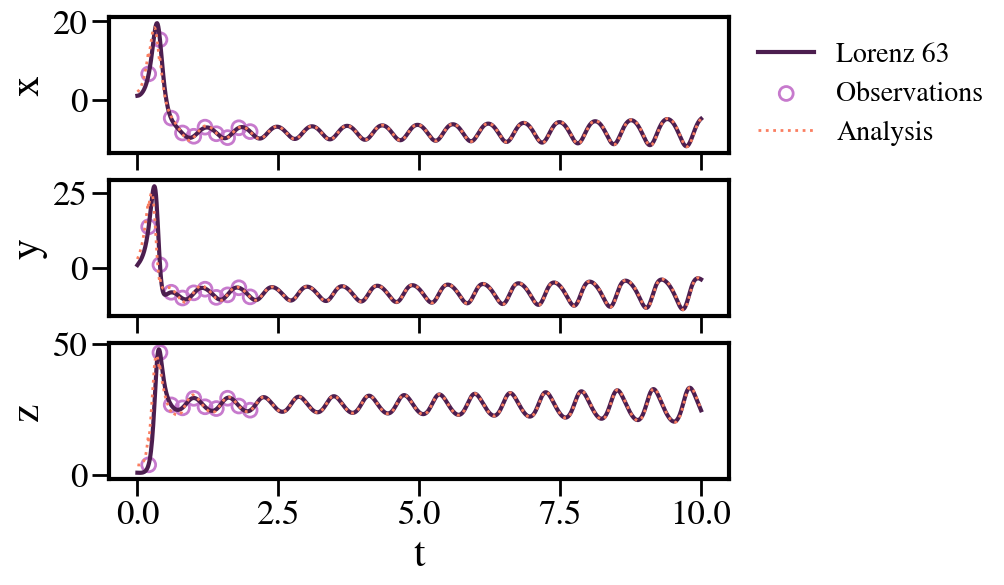

In [80]:
fig, axes = plt.subplots(3,1, sharex=True, figsize=(8,6))
labels = ['x', 'y', 'z']

for i in range(3):
    axes[i].plot(t, ut[i], lw=3,color='#4C1E4F', label='Lorenz 63')
    axes[i].set_ylabel(labels[i])

    axes[i].scatter(t_m, w[i], marker='o', facecolor='None', lw=2,s=100, edgecolor='#C77ACD', label='Observations')
    axes[i].plot(t, ua[i], color='#FA7E61', lw=2,ls=':', label='Analysis')


axes[2].set_xlabel('t')
axes[0].legend(frameon=False, bbox_to_anchor=(1.45,1))

An interesting question is what happens if our guess for the initial background is bad? Since the analysis is heavily influenced by the evolution of the background, this could potentially disrupt the entire thing.

In [97]:
ub_t0 = np.array([7.,7.,7.]) #initial condition for the poorly estimated background

ub = np.zeros([3,len(t)])
ub[:,0] = ub_t0

ua = np.zeros([3,len(t)])
ua[:,0] = ub_t0

km = 0
for k in range(nt):
    ub[:,k+1] = Runge_Kutta(Lorenz63,ub[:,k],dt,sigma,beta,rho)
    ua[:,k+1] = Runge_Kutta(Lorenz63,ua[:,k],dt,sigma,beta,rho)

    if (km<nt_m) and (k+1==ind_m[km]): #replace background with observations if available
        ua[:,k+1] = ua_3DVAR(ua[:,k+1],w[:,km],H,R,B,3)  
        km = km+1

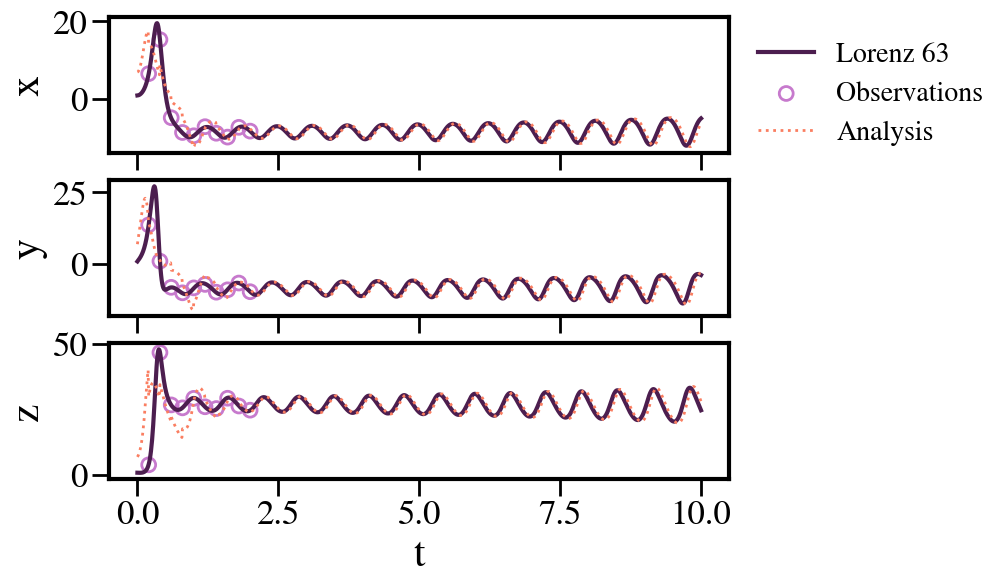

In [98]:
fig, axes = plt.subplots(3,1, sharex=True, figsize=(8,6))
labels = ['x', 'y', 'z']

for i in range(3):
    axes[i].plot(t, ut[i], lw=3,color='#4C1E4F', label='Lorenz 63')
    axes[i].set_ylabel(labels[i])

    axes[i].scatter(t_m, w[i], marker='o', facecolor='None', lw=2,s=100, edgecolor='#C77ACD', label='Observations')
    axes[i].plot(t, ua[i], color='#FA7E61', lw=2,ls=':', label='Analysis')


axes[2].set_xlabel('t')
axes[0].legend(frameon=False, bbox_to_anchor=(1.45,1))

You can see the wheels start to come off a bit. We still get the periodic nature of the system down and are at least aided in the beginning by the observations, but there's a lot of error between the true state and the analysis. This is the case lots of times in forecasting! A model of storm system or front can be displaced from the actual system by quite a lot; even though the model predicts the prescence of the storm, it can struggle to get both the location/timing and amplitude correct. How can we tackle that? And how do we evaluate a model's goodness/badness in these cases? And what if we have an ensemble of models?

## Correcting Position and Amplitude Errors with Field Alignment (Ravela+2006)

As an example, I'll walkthrough the two 1D examples of forecasts with amplitude and position errors. In the first example, the forecast ensemble has a position error but every ensemble member has the _same_ offset from the true position, in addition to amplitude errors.  

The last demo we did above and the first in Ravela+2006 show that typical data assimilation techniques like 3DVAR that consider only amplitude errors are unfit for these problems.

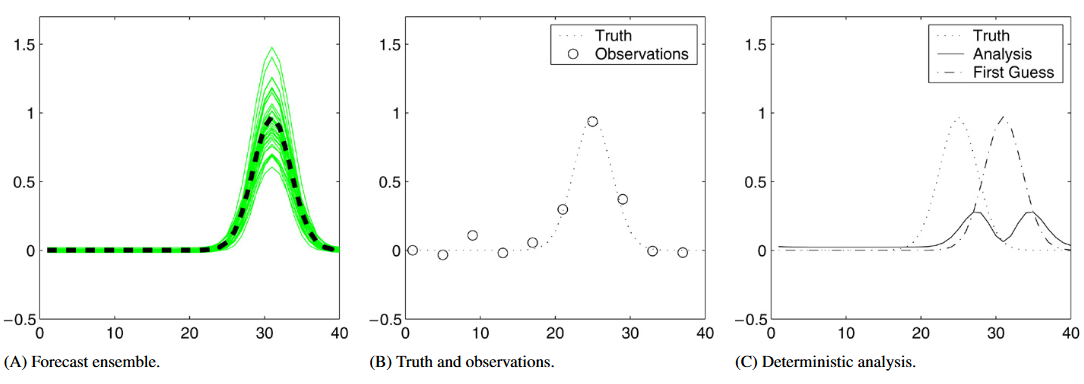

In the second example from Ravela, the ensemble again has position and amplitude errors but each member has a unique position offset.

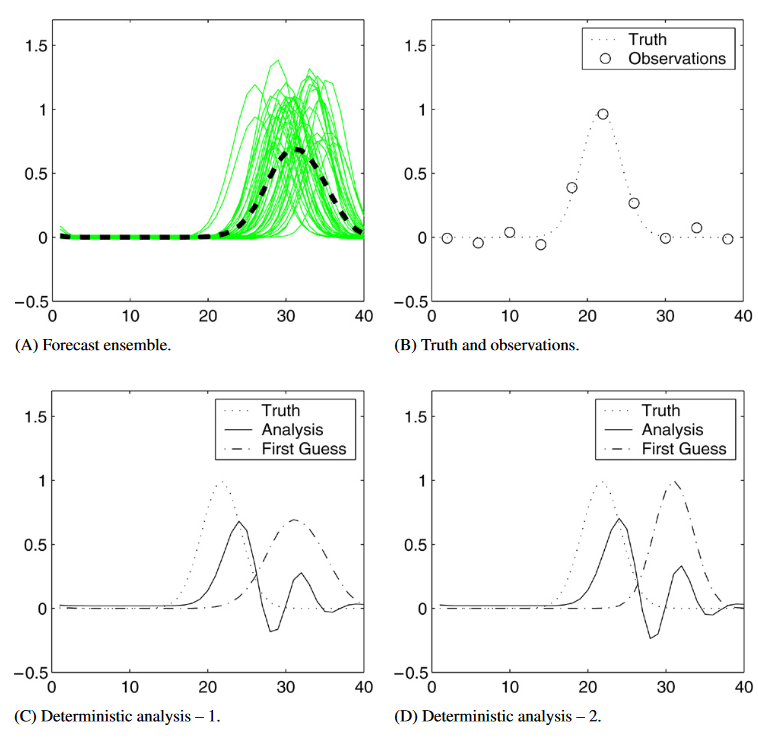

"The analysis from the procedure just discussed is shown. It is clear that the analysis (solid line) looks like neither the forecast ensemble nor the truth. It’s somewhere in between, being pulled by the observations in some places and the background at others. It has replaced a single front with a bimodal front of far weaker strength," (Ravela+2006).


"To address the position error problem, we reformulate the classical quadratic objective in a way that allows position adjustments in addition to amplitude adjustments. The key step in this new approach is to explicitly represent and minimize position errors. Therefore, we introduce auxiliary control variables (displacements) that are estimated along with amplitudes. The displacement variables are defined at each node of the grid representing the state and specify a deformation of the grid."

In [85]:
def generate_ensemble_front(p,n=1,p0=31., sigma0=2.):
    xf = np.exp((-(p-p0).T * (p-p0))/(2*sigma0**2))
    this_ens=[]
    for mem in range(n):
        a = np.random.normal(1,0.2,1)
        b = np.random.normal(0,0.01,1)

        this_ens.append(a*xf + b)

    return xf, this_ens
    

In [72]:
test = np.linspace(0,40,40)

In [86]:
mean_front, fronts = generate_ensemble_front(test,n=40)

In [87]:
truth = generate_ensemble_front(test, p0=25.)[0]

In [141]:
#define matrices
sig_m= 0.05  # standard deviation for measurement noise
R = sig_m**2*np.eye(10) #covariance matrix for measurement noise
H = np.eye(10)
observations = H@truth[::4] +  np.random.normal(0,sig_m,10)

Text(0, 0.5, 'amplitude')

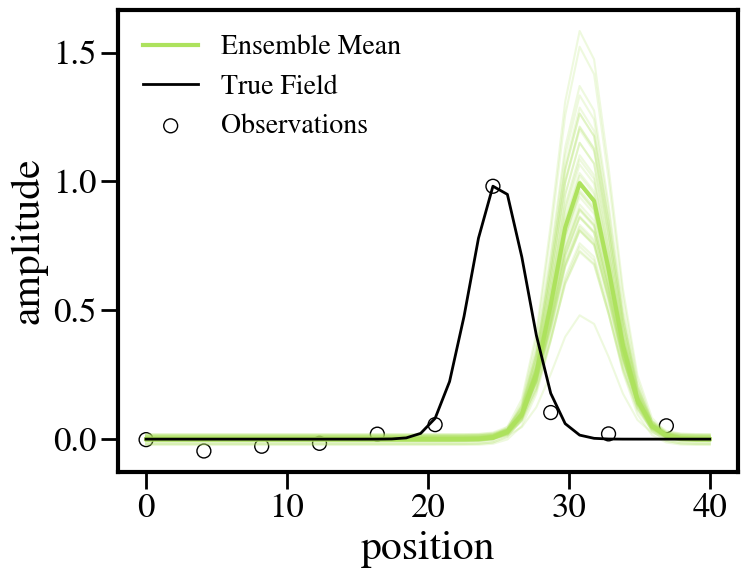

In [142]:
for i in range(40):
    plt.plot(test, fronts[i], color='#ADE25D', alpha=0.2)
plt.plot(test, mean_front, color='#ADE25D', lw=3, label='Ensemble Mean')
plt.plot(test, truth, color='black', lw=2, label='True Field')
#plt.ylim([0,1.5])
plt.scatter(test[::4], observations, edgecolor='black', s=100, marker='o',facecolor='None', label='Observations')
plt.legend(frameon=False)
plt.xlabel('position')
plt.ylabel('amplitude')

Now the trick here is to refactor the objective in the previous section to allow both position and amplitude adjustments. Ravela+2006 describe this as introducing abuliary control variables that are estimated along with the amplitudes. These variables describe the displacement at each point in the grid between the true state/observations and the background. The problem then is finding the model state (X, **q**) that has the maximum a posteriori probability in the distribution *P*(X, **q** | Y), where Y is the vector of observations and

$$ X = X(\textbf{r}) = \lbrace X[r_i^T] \rbrace$$

is the model-state vector at position indicies

$$ \textbf{r}^T = \lbrace r_i = (x_i, y_i)^T \rbrace. $$

Then **q** is the vector of displacements between model-state and true state

$$ \textbf{q}^T = \lbrace q_i = (\Delta x_i, \Delta y_i)^T \rbrace. $$

*X*(**r** - **q**) represents the diaplcement of *X* by **q**. We can find the optimal displacement via

$$ P(X, \textbf{q} | Y)  \propto P(Y | X, \textbf{q}) P(X^f | \textbf{q}) P(\textbf{q}) $$

Defining **p** = **r** - **q**, the amplitude + position correcting objective becomes

$$ \textit{J} (X, \textbf{q}) = {1 \over 2} (X(\textbf{p}) - X^f(\textbf{p}))^T B(\textbf{q}^{-1} (X(\textbf{p}) - X^f(\textbf{p})) + {1 \over 2} {Y - HX(\textbf{p}))^{T} \textbf{R}^{-1}(Y - HX(\textbf{p}))} + L(\textbf{q}) - {1 \over 2} ln(|B(\textbf{q})|) $$


Unfortunately, this cannot be solved as easily as the first objective function. Thus Ravela+2006 introduce a few assumptions and approximations in order to solve this iteratively. The idea is to solve the gradients ($\partial J \over \partial \textbf{q}$, $\partial J \over \partial X$) sequentially. First, by fixing X=X$^f$ and solving for the optimal displacement at each grid point $i$. Then use the aligned forecast to solve for the optimal amplitude. From $\partial J \over \partial \textbf{q}$, we get (where X = X$^f$ below):

$$ w_1 \nabla^2 q_i + w_2 \nabla (\nabla \cdot q_i) + \lbrace \nabla X^T |_\textbf{p} H^T R^{-1} \times (H X(\textbf{p}) - Y) \rbrace_i = 0 $$

where $w_1, w_2$ are weights that come from the prior on the displacement field, assuming smooth large-scale background flows. Even still, this equation is nonlinear so it must be solved iteratively in which **q** is calculated while the residual between the model and observation is held constant. This is then used to deform the model field for the next iteration and is repeated until the misfit with the observatrions does not improve or some iteration limit is reached. Then we will have X$^f$($\textbf{\^ p}$), the model field with optimal displacement, from which the covariance matrix B is computed. Finally, the analysis is obtained by plugging X$^f$($\textbf{\^ p}$) into $\partial J \over \partial X$ (where each p, q below is the optimized value found above):

$$ X_a (\textbf{p}) = X^f (\textbf{p}) + B_{q} H^T \times (HB_{q}H^T + R)^{-1} (Y - HX^f(\textbf{p})) $$



